In [201]:
from indra_cogex.client import Neo4jClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
client = Neo4jClient()

INFO: [2024-06-05 08:44:45] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2024-06-05 08:44:45] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


## **Create a Histogram to Find the Top 20 Journals Researching Cancer**

This code finds the top 20 journals researching lung cancer by finding the ratio of publications mentioning lung cancer to total publications for each journal, and creating a histogram to visualize it. I selected the second journal because it overall had more publications as compared to the first result despite having a slightly lower ratio. 

In [13]:
def get_df2():

    # cypher query to get the journal, name and publications
    # pubmed entries w mesh annotations, rel: annotated_with, find the mesh term for lung cancer and look up the pubmed ids that are 
    # annotated w that term and look for the journals 
    #  calculate the ratio, # publications about lung cancer/total publications to get who is publishing the most -> normalize the count
    
    cypher = """MATCH (n:BioEntity)<-[r:annotated_with]-(pub:Publication)-[:published_in]->(j:Journal) WHERE n.id = "mesh:D008175"
    WITH j, count (distinct pub) as LungPubs ORDER BY count (distinct pub) desc LIMIT 20
    MATCH (n1:BioEntity)<-[:annotated_with]-(pub1:Publication)-[:published_in]->(j:Journal) 
    RETURN j.name, j.id, count(distinct pub1) as AllPubs, LungPubs, LungPubs*100/count(distinct pub1) as Ratio 
    ORDER BY LungPubs*100/count(distinct pub1) DESC """

    results = client.query_tx(cypher)
    # loads the results into a dataframe 
    df = pd.DataFrame(results, columns=["name", "id", "Total Pub", "Lung Pub", "Ratio"])
    
    return df
    
df = get_df2()
df


,name,id,Total Pub,Lung Pub,Ratio
0,Clinical Lung Cancer,nlm:100893225,2138,2012,94
1,Lung Cancer,nlm:8800805,6770,6300,93
2,Journal of Thoracic Oncology,nlm:101274235,5480,4801,87
3,None,nlm:101126433,1995,1707,85
4,Thoracic Cancer,nlm:101531441,2465,1667,67
5,None,nlm:0413533,12377,1788,14
6,None,nlm:7810034,21263,2211,10
7,Journal of Clinical Oncology,nlm:8309333,25917,2446,9
8,International Journal of Radiation Oncology Bi...,nlm:7603616,24193,2258,9
9,None,nlm:8102988,24442,2218,9


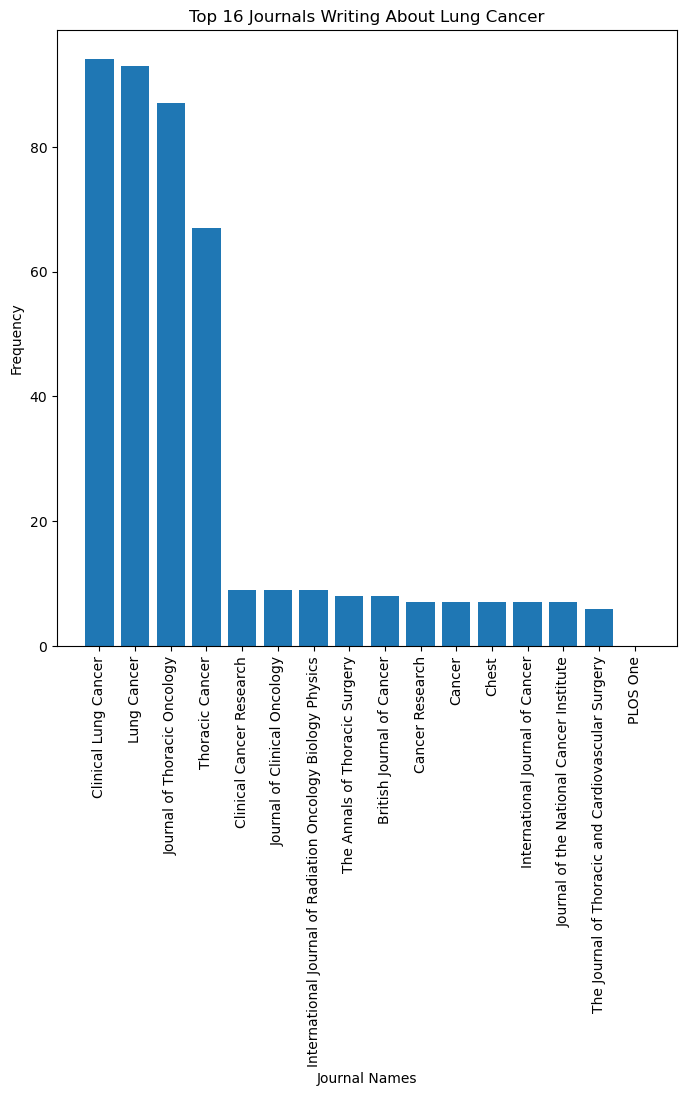

,level_0,index,name,id,Total Pub,Lung Pub,Ratio
0,0,0,Clinical Lung Cancer,nlm:100893225,2138,2012,94
1,1,1,Lung Cancer,nlm:8800805,6770,6300,93
2,2,2,Journal of Thoracic Oncology,nlm:101274235,5480,4801,87
3,3,4,Thoracic Cancer,nlm:101531441,2465,1667,67
4,4,10,Clinical Cancer Research,nlm:9502500,20160,1877,9
5,5,7,Journal of Clinical Oncology,nlm:8309333,25917,2446,9
6,6,8,International Journal of Radiation Oncology Bi...,nlm:7603616,24193,2258,9
7,7,11,The Annals of Thoracic Surgery,nlm:15030100R,39122,3295,8
8,8,12,British Journal of Cancer,nlm:0370635,24814,2028,8
9,9,13,Cancer Research,nlm:2984705R,53264,3828,7


In [199]:
# Sorts the dataframe to get the top publications
# Some of the journals were in another langauge causing the results to be null, and therefore needed to be dropped
df = df.sort_values(by = "Ratio", ascending = False)
df = df.dropna(axis = 0)
df = df.reset_index()

# plots a histogram of the top 16 publications 
def plot_histogram2():
    plt.figure(figsize=(8, 8))
    plt.title("Top 16 Journals Writing About Lung Cancer")
    plt.bar(df["name"].values, df["Ratio"].values)
    plt.xlabel("Journal Names")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()
    
plot_histogram2()
df

## **Finding Novel Genes**
**This code finds all of the genes relating to lung cancer in the database, and all the genes in the journal "Lung Cancer: Journal of the International Association for the Study of Lung Cancer", and finds the genes listed in the database that are not mentioned in the journal, the genes mentioned in the journal that are not listed in the database, and the common genes. Based off the genes listed in the database that were not mentioned in the journal, I manually looked up the genes and saw how many PubMed articles linked that specific gene to lung cancer, to identify genes that could be further studied to explore their correlation to lung cancer.**

In [53]:
def get_gene_lists():
    
    # cypher queries to get genes from the journal and database relating to lung cancer
    journal_cypher = '''MATCH p3= (gene1:BioEntity)-[r:indra_rel]->(gene2:BioEntity) 
    MATCH p4=(e:Evidence)-[:has_citation]->(pub:Publication)-[]->(j:Journal) 
    WHERE gene1.id <> gene2.id AND e.stmt_hash = r.stmt_hash AND j.id='nlm:8800805' unwind [gene1, gene2] as gene 
    RETURN gene.name, gene.id, count(r)
    ORDER BY count(r) desc'''
    database_cypher = """MATCH p1=(gene1)-[:gene_disease_association]->(subdisease)-[:isa*0..]->(disease) WHERE disease.id in ["mesh:D008175",'doid:3905']
RETURN distinct gene1.name, gene1.id"""
    
    journal_results = client.query_tx(journal_cypher)
    database_results = client.query_tx(database_cypher)

    # loads the results into 2 dataframes
    # returns the name, gene id, and number of indra statements for each gene in the journal 
    journal_df = pd.DataFrame(journal_results, columns=["name", "gene_id", "# indra statements"])
    database_df = pd.DataFrame(database_results, columns=["name", "gene_id"])

    return journal_df, database_df
    
journal_df, database_df = get_gene_lists()

# for the journal, filters for genes starting with hgnc to match with the database
journal_df = journal_df[journal_df["gene_id"].str.startswith("hgnc")]
# creates a "novel" dataframe which contains the genes present in the journal but not in the database
novel_df = journal_df[~journal_df["gene_id"].isin(database_df["gene_id"])]



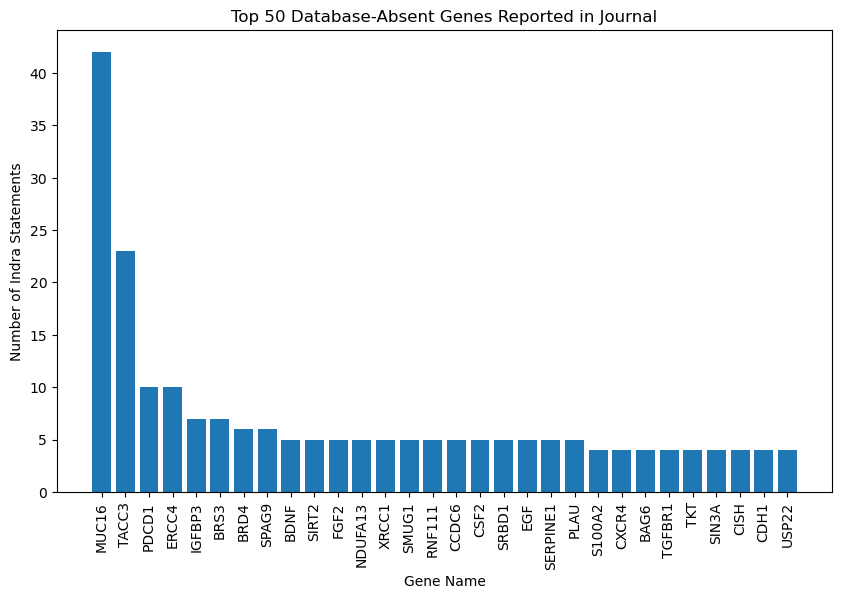

In [42]:
# Creates a histogram to display the top 50 genes that were present in the journal but not the database
plt.figure(figsize=(10, 6))
plt.bar(novel_df["name"].head(50), novel_df["# indra statements"].head(50))
plt.xlabel("Gene Name")
plt.ylabel("Number of Indra Statements")
plt.title("Top 50 Database-Absent Genes Reported in Journal")
plt.xticks(rotation=90)
plt.show()


In [202]:
novel_df.head(10)

,name,gene_id,# indra statements
18,MUC16,hgnc:15582,89
22,CDH1,hgnc:1748,75
35,PDCD1,hgnc:8760,51
40,SRC,hgnc:11283,46
41,PPARG,hgnc:9236,46
43,TACC3,hgnc:11524,46
49,EGF,hgnc:3229,40
50,CISH,hgnc:1984,40
58,BAX,hgnc:959,37
59,FGF2,hgnc:3676,37


## Display Indra Statements
Wrote a cypher query to get the indra statements for a given gene, then use indra.assemblers.html to create an html page with the INDRA statements

In [203]:
def get_statements():
    # gets a list of the top 6 gene ids and names 
    gene_ids = novel_df.head(6)["gene_id"]
    gene_names = novel_df.head(6)["name"]
    
    # initializes empty lists
    string_list =  []
    df_list = []

    # for loop to iterate through each gene 
    for id, name in zip(gene_ids, gene_names):
        # cypher to get the indra statements, uses f-string formatting for query to efficently test each gene
        indra_cypher = f"MATCH p3= (gene1:BioEntity)-[r:indra_rel]->(gene2:BioEntity) MATCH p4=(e:Evidence)-[:has_citation]->(pub:Publication)-[]->(j:Journal) WHERE gene1.id <> gene2.id AND e.stmt_hash = r.stmt_hash AND j.id='nlm:8800805' AND (gene1.id = '{id}' OR gene2.id ='{id}') unwind [gene1, gene2] as gene RETURN gene.name, gene.id, r.stmt_json"
        indra_results = client.query_tx(indra_cypher)
        
        # saves result in a dataframe that contains the name, id and indra statements in string json form
        indra_df = pd.DataFrame(indra_results, columns=["name", "gene_id", "indra statements"])
        # the query returns "double" the results due to how it was written, so the dataframe needs to be filtered for the correct gene 
        filtered_indra = indra_df[indra_df["name"] == name]
        filtered_indra = filtered_indra.reset_index()

        # returns a list of data frames and a nested list of indra statements as json strings 
        df_list.append(filtered_indra)
        json_strings = list(filtered_indra["indra statements"].values)
        string_list.append(json_strings)
        
    return df_list, string_list
df_list, string_list = get_statements()

In [198]:
# iterates through the gene name and json strings for each gene 
for genes, json_strings in zip(gene_names, string_list):
    stmt_jsons = []
    # iterates through the individual json string within the statements for each gene 
    # and converts it to an INDRA statement object
    for stmt_json_string in json_strings:
        stmt_jsons.append(json.loads(stmt_json_string))
    stmts = stmts_from_json(json_in=stmt_jsons)

    # uses HtmlAssembler to get html pages of INDRA statements for each gene 
    ha = HtmlAssembler(stmts, title='Statements for %s' % genes, db_rest_url='https://db.indra.bio')
    ha.save_model('%s_statements.html' % genes)
    print(genes)

MUC16
CDH1
PDCD1
SRC
PPARG
TACC3
